<a href="https://colab.research.google.com/github/CorsiDanilo/big-data-computing-project/blob/main/1_Data_cleaning_%2B_exploration_%2B_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



# Global Constants


In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"

GDRIVE_DATASET_RAW_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/raw"
GDRIVE_DATASET_TEMP_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/temp"
GDRIVE_DATASET_OUTPUT_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/output"

GDRIVE_DATASET_NAME = "bitcoin_blockchain_data_1d"
GDRIVE_DATASET_NAME_EXT = "/" + GDRIVE_DATASET_NAME + ".csv"

GDRIVE_DATASET = GDRIVE_DATASET_RAW_DIR + GDRIVE_DATASET_NAME_EXT

#  Import useful Python packages

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import cycle

import plotly.express as px

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import gc

# **Google Colab Setup**

In [3]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


# Data Exploration
In this section we are going to explore the dataset, to clean it from null values, and to determine which features are relevant and which are not.

First, we import the dataset from Google Drive, check the shape and print out the schema.

In [12]:
df = pd.read_csv(GDRIVE_DATASET)
df

,timestamp,market-price,market-cap,total-bitcoins,trade-volume,blocks-size,avg-block-size,n-transactions-total,n-transactions-per-block,hash-rate,difficulty,miners-revenue,transaction-fees-usd,n-unique-addresses,n-transactions,estimated-transaction-volume-usd
0,2012-01-01,5.04,4.032958e+07,8001900.00,0.000000e+00,861.941752,0.017073,2119853.0,32.686275,8.591401e+00,1.159929e+06,4.260652e+04,18.516384,8531.0,5001.0,1.016110e+06
1,2012-01-02,5.27,4.223035e+07,8013350.00,0.000000e+00,864.547504,0.019121,2124845.0,35.827815,8.764382e+00,1.159929e+06,6.301249e+04,35.989325,8928.0,5410.0,7.508830e+05
2,2012-01-03,5.45,4.223035e+07,8013350.00,0.000000e+00,867.445999,0.018212,2130220.0,36.308176,9.340986e+00,1.159929e+06,4.662806e+04,30.560129,9528.0,5773.0,6.037982e+05
3,2012-01-04,5.37,4.309479e+07,8025100.00,0.000000e+00,870.374487,0.019351,2135991.0,38.463087,8.879703e+00,1.159929e+06,4.706558e+04,78.082768,9542.0,5731.0,7.495462e+05
4,2012-01-05,5.80,4.661373e+07,8036850.00,0.000000e+00,873.246150,0.024677,2141802.0,47.578231,8.476080e+00,1.159929e+06,5.369470e+04,44.697203,11636.0,6994.0,1.614569e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,2022-12-26,16826.86,3.240861e+11,19243875.00,2.726254e+07,445014.991139,1.119264,790945257.0,1732.589147,2.267765e+08,3.536407e+13,1.410410e+07,296889.796293,548937.0,223504.0,8.333855e+08
4001,2022-12-27,16915.70,3.240861e+11,19243875.00,3.983614e+07,445159.265994,1.376405,791168987.0,2081.382609,2.021651e+08,3.536407e+13,1.248977e+07,400541.066884,593337.0,239359.0,1.240817e+09
4002,2022-12-28,16699.00,3.205852e+11,19245118.75,8.334204e+07,445318.173024,1.026325,791410511.0,1624.696429,2.953368e+08,3.536407e+13,1.784473e+07,344406.479474,661225.0,272949.0,1.926197e+09
4003,2022-12-29,16539.28,3.203364e+11,19246356.25,9.358288e+07,445490.189205,1.263212,791683136.0,1886.205674,2.478720e+08,3.536407e+13,1.497709e+07,341839.738394,668338.0,265955.0,2.178953e+09


In [13]:
df.dtypes

timestamp                            object
market-price                        float64
market-cap                          float64
total-bitcoins                      float64
trade-volume                        float64
blocks-size                         float64
avg-block-size                      float64
n-transactions-total                float64
n-transactions-per-block            float64
hash-rate                           float64
difficulty                          float64
miners-revenue                      float64
transaction-fees-usd                float64
n-unique-addresses                  float64
n-transactions                      float64
estimated-transaction-volume-usd    float64
dtype: object

In [26]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
market-price,4005.0,9.721464e+03,1.504847e+04,4.380000e+00,3.280000e+02,2.557000e+03,1.035944e+04,6.756217e+04
market-cap,4005.0,1.795119e+11,2.841363e+11,3.670856e+07,4.507305e+09,4.191302e+10,1.848360e+11,1.291247e+12
total-bitcoins,4005.0,1.556983e+07,3.077623e+06,8.001900e+06,1.334218e+07,1.642044e+07,1.829588e+07,1.924759e+07
trade-volume,4005.0,1.948847e+08,3.507304e+08,0.000000e+00,2.618163e+06,3.420878e+07,2.437812e+08,4.956850e+09
blocks-size,4005.0,1.566835e+05,1.393713e+05,8.619418e+02,2.425125e+04,1.232185e+05,2.696634e+05,4.456683e+05
avg-block-size,4005.0,7.500804e-01,4.349633e-01,1.488233e-02,2.890024e-01,8.604732e-01,1.108843e+00,1.571701e+00
n-transactions-total,4005.0,2.922355e+08,2.551614e+08,2.119853e+06,4.802446e+07,2.360262e+08,5.164131e+08,7.919480e+08
n-transactions-per-block,4005.0,1.331689e+03,7.589273e+02,3.209239e+01,5.066154e+02,1.516156e+03,1.978565e+03,2.762541e+03
hash-rate,4005.0,5.401081e+07,7.346725e+07,7.709763e+00,2.435976e+05,5.302596e+06,1.053248e+08,3.167823e+08
difficulty,4005.0,7.470429e+12,1.014939e+13,1.159929e+06,3.466143e+10,7.116972e+11,1.471521e+13,3.695049e+13


Brief description of the dataset:

Contains **❓❓** records of bitcoin historical data from 2012 to 2022; each record, contains the following set of **15** columns:


**Currency Statistics**
* "timestamp": Duration of the data (in our case from 2012-01-01 to 2022-12-31)
* "market-price": The average USD market price across major bitcoin exchanges.
* "total-bitcoins": The total number of mined bitcoin that are currently circulating on the network.
* "market-cap" (USD) The total USD value of bitcoin in circulation.
* "trade-volume" (USD): The total USD value of trading volume on major bitcoin exchanges.

**Block Details**

* "blocks-size" (MB): The total size of the blockchain minus database indexes in megabytes.
* "avg-block-size" (MB): The average block size over the past 24 hours in megabytes.
* "n-transactions-total": The total number of transactions on the blockchain.
* "n-transactions-per-block": The average number of transactions per block over the past 24 hours.

**Mining Information**

* "hash-rate" (TH/s): The estimated number of terahashes per second the bitcoin network is performing in the last 24 hours.
* "difficulty": A relative measure of how difficult it is to mine a new block for the blockchain.
* "miners-revenue" (USD): Total value of coinbase block rewards and transaction fees paid to miners.
* "transaction-fees-usd" (USD): The total USD value of all transaction fees paid to miners. This does not include coinbase block rewards.

**Network Activity**

* "n-unique-addresses": The total number of unique addresses used on the blockchain.
* "n-transactions": The total number of confirmed transactions per day.
* "estimated-transaction-volume-usd" (USD): The total estimated value in USD of transactions on the blockchain. This does not include coins returned as change.

In [23]:
# TO DO: da sistemare ❗
def show_metrics(dataset, feature):
  trace = go.Scatter(
      x = dataset['timestamp'],
      y = dataset[feature].astype(float),
      mode = 'lines',
      name = feature
  )

  layout = dict(
      title=feature,
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  #change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
for index, feature in enumerate(df.columns[1:], start=1):
  show_metrics(df, feature)

#  Feature Selection ❗

Source: https://medium.com/experimenting-with-deep-learning/predictbit-d0c1e44990a3


The aim of this section is to remove the features that have less of an impact to the final result from the dataset. This operation is called feature selection. Let's plot a correlation map to see how features are correlated among each other:

In [23]:
copy_df = df.iloc[:, 1:]
cor = copy_df.corr().abs()

all_features = copy_df.columns

cont_columns = copy_df.columns[1:]
dep_var = 'market-price'

Plotting a correlation heatmap for Market Price (our target) against all the continuous features yields the following:

<ipython-input-8-3812ecf78d1a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



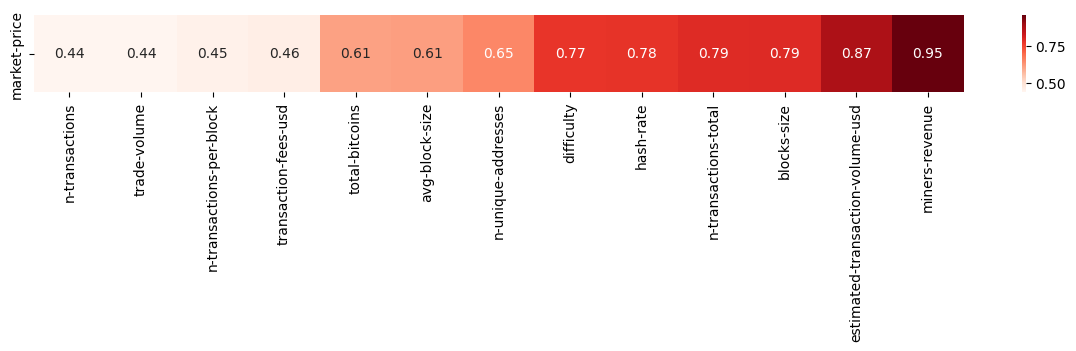

In [8]:
# Correlation b/w Market Price and Continuous Features:
cont_df = copy_df[cont_columns]
cont_df[dep_var] = copy_df[dep_var]
cont_corr_df = cont_df.corr()
plt.figure(figsize=(15,1))
sns.heatmap(cont_corr_df.sort_values(by=dep_var, axis=1).drop(dep_var, axis=1).tail(1), annot=True, cmap=plt.cm.Reds)
plt.show()

Before we eliminate any columns, lets first filter out and keep features that satisfy this first condition: (1) highly correlated to our target.

We can then visualize this filtered subset with a Seaborn heat map to inductively identify which features are also correlated to each other.

To get this to work, first, we’ll collect all correlation comparisons to our target in a variable called “cor_target”.

In [27]:
cor_target = cor[dep_var]

(1) filter by a correlation threshold of our choosing (for example, I’m going with 0.6, so any feature with a correlation to our target of less than .6 will gets dropped). This is step one of the inductive elimination process.

(2) create a new data frame with features from the previous step

(3) grab the correlations matrix for this new data frame and visualize to see whether or not any of these features are also highly correlated with each other (again, using .6 as a threshold).

I like to think of this as a nested correlation matrix:

<ipython-input-32-b658029f5ce2>:10: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



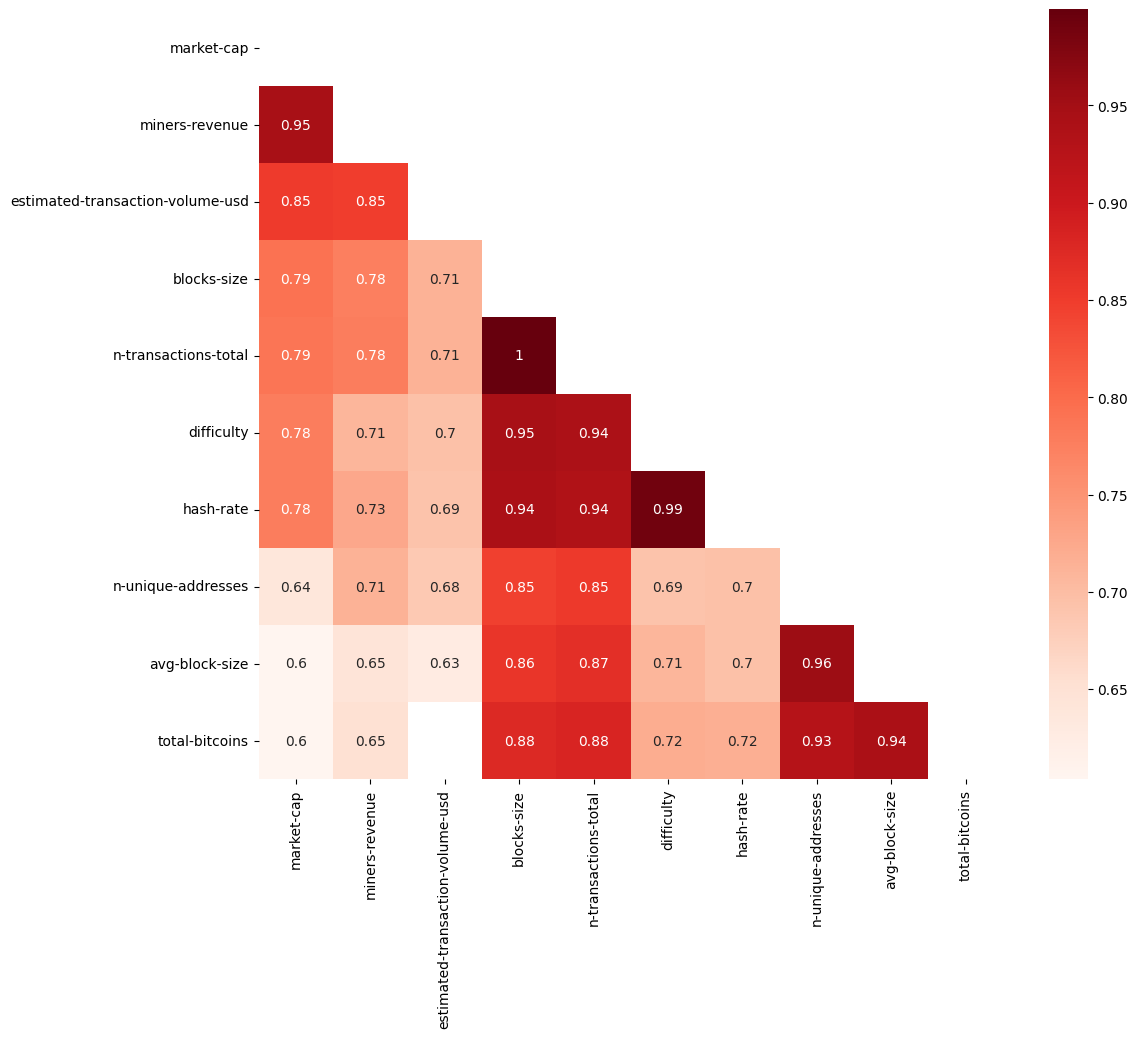

(['market-cap',
  'miners-revenue',
  'estimated-transaction-volume-usd',
  'blocks-size',
  'n-transactions-total',
  'difficulty',
  'hash-rate',
  'n-unique-addresses',
  'avg-block-size',
  'total-bitcoins'],
 None)

In [32]:
# Identifying Features Highly Correlated with Target and Other Features:
relevant_features = cor_target[cor_target>0.6]

rel_df = relevant_features.to_frame() #.transpose()
rel_df = rel_df.sort_values(dep_var, ascending=False)
rel_columns = rel_df[1:].index.values.tolist()
rel_corr_df = df[rel_columns].corr()

plt.figure(figsize=(12,10))
mask = np.zeros_like(rel_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rel_corr_df[rel_corr_df>.6], annot=True, cmap=plt.cm.Reds, mask=mask)
rel_columns, plt.show()

The above heat map illustration demonstrates that several of these filtered features are also correlated to each other.

In this scenario, we want to minimize the number of red cells by, again, filtering by a certain threshold.

A utility function to keep code DRY, should you find you want to iterate.

I used a higher threshold, here, to prevent dropping too many features.

In [29]:
# Reducing Dimensionality of Correlation Matrix:
def dimentionalize_corr_matrix(cor_df, upper_bound=0.95):
  upper = cor_df.where(np.triu(np.ones(cor_df.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > upper_bound)]
  rel_df_clean = cor_df.drop(cor_df[to_drop], axis=0)
  rel_df_clean =  rel_df_clean.drop( rel_df_clean[to_drop], axis=1)
  return rel_df_clean


rel_df_clean = dimentionalize_corr_matrix(rel_corr_df, .9)
rel_columns = rel_df_clean.columns.tolist()

plt.figure(figsize=(12,10))
mask = np.zeros_like(rel_df_clean, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rel_df_clean, annot=True, cmap=plt.cm.Reds, mask=mask)
rel_columns, plt.show()

NameError: ignored

The outputted features: 'market-cap', 'estimated-transaction-volume-usd', 'blocks-size', 'n-unique-addresses'.

For the purpose of this experiment, we’ll call these columns “relevant columns”.

Unlike my approach from earlier, the RFE method recursively goes through the feature set, removing columns to get the best accuracy level it deems possible.

To use RFE, we first have to declare a sklearn linear regression model (not to be confused with the pyspark Linear Regression model we’ll be using in next steps) and pass that model to the RFE method with the maximum number of features we’d like to extract.

We’re looking for 7 recommended features (the same list length as “relevant columns”) from the RFE model to create a second test group of features. To use the RFE method, we also have to get a list of targets to support RFE’s accuracy check:

In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression as sklearnLR

model = sklearnLR()
rfe = RFE(model, step = 7)
y = copy_df[dep_var].tolist()

We fit the RFE model on the Sklearn Linear Regression model, along with the inputs and targets:

In [13]:
X_rfe = rfe.fit_transform(copy_df.drop(dep_var, axis=1), y)
model.fit(X_rfe, y)
temp = pd.Series(rfe.support_,index = copy_df.drop(dep_var, axis=1).columns)
selected_features_rfe = temp[temp==True].index.values.tolist()
print(selected_features_rfe)

['total-bitcoins', 'blocks-size', 'avg-block-size', 'n-transactions-per-block', 'miners-revenue', 'n-unique-addresses', 'n-transactions']


The outputted features: 'total-bitcoins', 'blocks-size', 'avg-block-size', 'n-transactions-per-block', 'miners-revenue', 'n-unique-addresses', 'n-transactions'.

Vastly different from the list generated earlier! Let’s see how it goes.

# Stationarity and detrending ❗

Source: https://www.kaggle.com/code/debashis74017/time-series-forecasting-itcoin-price?scriptVersionId=113747601&cellId=25

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['market-price'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Stats value is greater than all critical values, and p-value is also greater than 0.05. So we can strongly reject the null hypothesis, and conclude that, Price value is Non-Stationary.

Let's apply log transformation to the data and test again

In [ ]:
from numpy import log

result = adfuller((log(df['market-price'])), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

After applying Log transformation also, ADF Stats value is greater than all critical values, and p-value is also greater than 0.05. It seems, Price value is purely Non-Stationary.

### KPSS test - Kwiatkowski Phillips Schmidt Shin
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [ ]:
from statsmodels.tsa.stattools import kpss

result = kpss(copy_df['market-price'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');

The output of the KPSS test contains 4 things:

1. The KPSS statistic
2. p-value
3. Number of lags used by the test
4. Critical values

The p-value reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.

The KPSS statistic is the actual test statistic that is computed while performing the test.

In order to reject the null hypothesis, the test statistic should be greater than the provided critical values. If it is in fact higher than the target critical value, then that should automatically reflect in a low p-value.

That is, if the p-value is less than 0.05, the kpss statistic will be greater than the 5% critical value.

Finally, the number of lags reported is the number of lags of the series that was actually used by the model equation of the kpss test. By default, the statsmodels kpss() uses the ‘legacy’ method. In legacy method, int(12 * (n / 100)**(1 / 4)) number of lags is included, where n is the length of the series.

Here we find that, KPSS stats value is too high than critical values.

So, we concluded that this time series is Non-Stationary

# Output ❗

Saving the different type of selected features

In [28]:
all_features.to_csv(GDRIVE_DATASET_OUTPUT_DIR + "/" + 'all_features.csv', index=False)
rel_columns.to_csv(GDRIVE_DATASET_OUTPUT_DIR + "/" + 'rel_columns.csv', index=False)
selected_features_rfe.to_csv(GDRIVE_DATASET_OUTPUT_DIR + "/" + 'selected_features_rfe.csv', index=False)

AttributeError: ignored